In [1]:
# # GPU allocation
# from gpuutils import GpuUtils
# GpuUtils.allocate(gpu_count=1, framework='keras')

# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)
# # --------------

# Imports
import matplotlib.pyplot as plt
import numpy as np
from constants import plots_dir, datapath, data_filename, label_filename, test_file_ids, dataset_run
from toolbox import get_pred_angle_diff_data, load_file_all_properties
import sys
import argparse
import os
import time
import pickle
from NuRadioReco.utilities import units
from scipy import stats
from radiotools import stats as rtSTATS
from termcolor import colored
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from radiotools import plthelpers as php
from tensorflow import keras
from radiotools import helper as hp
# -------


# Parse arguments
# parser = argparse.ArgumentParser(description='Plot performance data')
# parser.add_argument('--eps', dest='eps', action='store_true', help="flag to image as .eps instead of .png")
# parser.add_argument('--median', dest='median', action='store_true', help="flag to do median instead of mean")
# parser.add_argument('--sixtyeight', dest='sixtyeight', action='store_true', help="flag to do 68 percent interval")
# parser.set_defaults(eps=False)
# parser.set_defaults(median=False)
# parser.set_defaults(sixtyeight=False)


# args = parser.parse_args()
# eps = args.eps
# median = args.median


# Save the run name
run_name = f"run{dataset_run}"
if run_name == "runF1.1":
    emission_model = "Alvarez2009 (had.)"
elif run_name == "runF2.1":
    emission_model = "ARZ2020 (had.)"
elif run_name == "runF3.1":
    emission_model = "ARZ2020 (had. + EM)"

print(colored(f"Plotting resolution as function of neutrino properties for {run_name}...", "yellow"))

# Define 68 % interval statistic function
def calculate_percentage_interval(angle_difference_data):
    percentage=0.68
    N = angle_difference_data.size
    weights = np.ones(N)

    angle = rtSTATS.quantile_1d(angle_difference_data, weights, percentage)

    return angle


# Make sure plots folder exists
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

plot_dir = f"{plots_dir}/{run_name}_plots"
plot_dir_old = f"{plots_dir}/{run_name}_plots/old"

# Make sure folder inside plot_folder exists for the plots
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Make sure folder inside plot_folder exists for the plots
if not os.path.exists(plot_dir_old):
    os.makedirs(plot_dir_old)

# Make sure predicted file exists, otherwise run evaluator
prediction_file = f'{plots_dir}/model.{run_name}.h5_predicted.pkl'
if not os.path.isfile(prediction_file):
    print("Prediction file does not exist, running evaluator...")
    os.system(f"python evaluator.py")

# Load test file data
    # Load first file
data, nu_direction, nu_zenith, nu_azimuth, nu_energy, nu_flavor, shower_energy = load_file_all_properties(test_file_ids[0])

    # Then load rest of files
if len(test_file_ids) > 1:
    for test_file_id in test_file_ids:
        if test_file_id != test_file_ids[0]:
            data_tmp, nu_direction_tmp, nu_zenith_tmp, nu_azimuth_tmp, nu_energy_tmp, nu_flavor_tmp, shower_energy_tmp = load_file_all_properties(test_file_id)

            data = np.concatenate((data, data_tmp))
            nu_direction = np.concatenate((nu_direction, nu_direction_tmp))
            nu_zenith = np.concatenate((nu_zenith, nu_zenith_tmp))
            nu_azimuth = np.concatenate((nu_azimuth, nu_azimuth_tmp))
            nu_energy = np.concatenate((nu_energy, nu_energy_tmp))
            nu_flavor = np.concatenate((nu_flavor, nu_flavor_tmp))
            shower_energy = np.concatenate((shower_energy, shower_energy_tmp))


# Get angle difference data
angle_difference_data = get_pred_angle_diff_data(run_name)

sigma_68_string = "_{68}"


# --------- SNR plotting ---------
max_LPDA = np.max(np.max(np.abs(data[:, 0:4, :]), axis=2), axis=1)

SNR_data = max_LPDA[:, 0] / 10.



Plotting resolution as function of neutrino properties for runF3.1...
loading file 47
finished loading file 47 in 7.4923906326293945s
loading file 48
finished loading file 48 in 7.456103324890137s
loading file 49
finished loading file 49 in 7.425824165344238s


(299992,) (299992,)
[18.02053147 18.02053147 18.05192505 ... 17.29274805 17.29274805
 17.25472311]
[3.35257148 6.34961204 3.88981001 ... 3.94126384 5.59031683 7.63778271]
0
Plotting angular resolution depending on properties for runF3.1!



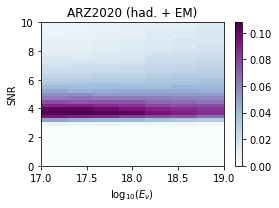

In [3]:

from matplotlib import pyplot as plt
from toolbox import get_2dhist_normalized_columns

plt.rcParams["figure.figsize"] = (4,3)

# Constants
cmap = "BuPu"
ylabel = r"SNR"
xlabel = r"$\log_{10}(E_{\nu})$"
xbins = np.linspace(17, 19, 8) 
ybins = np.linspace(0, 10, 40)
plot_title = f"{run_name}"

if dataset_run == "F1.1": # Alvarez2009 (had.)
    # plot_title = "Heatmap of predicted and true shower energies\nfor dataset Alvarez2009 (had.)"
    plot_title = "Alvarez2009 (had.)"
elif dataset_run == "F2.1": # ARZ2020 (had.)
    # plot_title = "Heatmap of predicted and true shower energies\nfor dataset ARZ2020 (had.)"
    plot_title = "ARZ2020 (had.)"
elif dataset_run == "F3.1": # ARZ2020 (had. + EM)
    # plot_title = "Heatmap of predicted and true shower energies\nfor dataset ARZ2020 (had. + EM)"
    plot_title = "ARZ2020 (had. + EM)"

nu_energy_log10 = np.log10(nu_energy)

print(nu_energy_log10.shape, SNR_data.shape)
print(nu_energy_log10)
print(SNR_data)



# for cscale in ["linear", "log"]:
for cscale in ["linear"]:
    file_name = f"{plots_dir}/SNR_VS_ENERGY_2dhistogram_{run_name}_cscale{cscale}.pdf"

    # Also plot a heatmap of the scatter plot instead of just dots
    fig = plt.figure()
    ax = fig.gca()
    pc, cb = get_2dhist_normalized_columns(nu_energy_log10, SNR_data, fig, ax, binsx=xbins, binsy=ybins, cmap=cmap)
    # ax.set_aspect('equal', 'box')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(plot_title)

    # Plot a black line through the middle
    xmin = min(SNR_data)
    xmax = max(SNR_data)
    ymin = min(nu_energy_log10)
    ymax = max(nu_energy_log10)

    # ax.plot([min(xmin, ymin), max(xmax, ymax)], [min(xmin, ymin), max(xmax, ymax)], 'k--')

    ax.set_xlim(17, 19)
    ax.set_ylim(0, 10)

    # if dataset_run == "F3.1":
        # ax.set_xlim(17, 19)
    #     ax.set_ylim(17, 19)

    plt.tight_layout()
    plt.savefig(file_name)






print(colored(f"Plotting angular resolution depending on properties for {run_name}!", "green", attrs=["bold"]))
print("")